# Signal-to-noise ratio

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * run: 2023_10_18
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)


### Prerequisites

These pipelines must have been run before:

1. fit silico amplitude and noise to in vivo per layer:

```bash
sbatch cluster/processing/fitting/marques/fit_marques_silico_l1.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l2_3.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l4.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l5.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l6.sbatch
```

2. Process silico traces:

```bash
sbatch cluster/processing/marques_silico/process.sbatch
```

### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [34]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad
CONTACTS = np.arange(0, 384, 1)

# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values() 
RAW_PATH_vivo = data_conf_vivo["raw"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]


# silico
data_conf_sili, param_conf_sili = get_config("silico_neuropixels", "2023_10_18").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_sili = data_conf_sili["postprocessing"]["trace_snr"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (3, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['lines.linewidth'] = 1.1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['ytick.major.size'] = 14
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 6

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-02-03 19:21:32,088 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-03 19:21:32,099 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-03 19:21:32,100 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-03 19:21:32,117 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Utils


In [2]:
def write_npy(anr, file_write_path: str):
    """write npy file

    Args:
        anr (_type_): _description_
        file_write_path (str): file path
    """
    parent_path = os.path.dirname(file_write_path)
    if not os.path.isdir(parent_path):
        os.makedirs(parent_path)
    np.save(file_write_path, anr, allow_pickle=True)

### Compute SNR p-dist for sites in cortex

* we plot: 
    * on logscale to increase the visibility of the SNR dist. which decays exponentially.
    * only the upper confidence interval (because the lower ci is uninformative; it goes to infinity when negative on a logscale)

In [10]:
# takes 14 min

# 1 - Load silico and vivo traces
PreRecording_sili = si.load_extractor(PREP_PATH_sili)
PreRecording_vivo = si.load_extractor(PREP_PATH_vivo)
traces_sili = PreRecording_sili.get_traces()
traces_vivo = PreRecording_vivo.get_traces()

# 2 - get good sites (in cortex)
# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = PreRecording_sili.get_property("layers")
site_layers_sili[site_layers_sili == "L2"] = "L2_3"
site_layers_sili[site_layers_sili == "L3"] = "L2_3"
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = PreRecording_vivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

# 3 - re-compute and save SNRs
# TODO: use multiprocessing to compute snr
snr_sili = amplitude.compute_snr(traces_sili, sites_sili)
snr_vivo = amplitude.compute_snr(traces_vivo, sites_vivo)
write_npy(snr_vivo, SNR_PATH_vivo)
write_npy(snr_sili, SNR_PATH_sili)

# 3 - or load
# snr_vivo = np.load(SNR_PATH_vivo)
# snr_sili = np.load(SNR_PATH_sili)

# takes 2 min

# Keep only preprocessed data for sites in cortex
traces_sili = traces_sili[:, sites_sili]
traces_vivo = traces_vivo[:, sites_vivo]
layers_sili = site_layers_sili[sites_sili]
layers_vivo = site_layers_vivo[sites_vivo]

site_layers_sili = site_layers_sili[sites_sili]
site_layers_vivo = site_layers_vivo[sites_vivo]

In [12]:
# takes 3 min

N_BINS = 100

# 1 - calculate common bins (2 mins)
snr_max = np.max([np.array(snr_vivo).max(), np.array(snr_sili).max()])
snr_min = np.min([np.array(snr_vivo).min(), np.array(snr_sili).min()])
step = (snr_max - snr_min) / N_BINS
bins = np.arange(snr_min, snr_max + step / 2, step)

# 2- Compute the snr pdf stats over sites (1 min)
# vivo
mean_vivo, ci_vivo = amplitude.compute_anr_proba_dist_stats(snr_vivo, bins)
# silico
(
    mean_sili,
    ci_sili,
) = amplitude.compute_anr_proba_dist_stats(snr_sili, bins)

In [13]:
# sanity check probabilities
assert 1 - sum(mean_vivo) < 1e-15, "probabilities should sum to 1"
assert 1 - sum(mean_sili) < 1e-15, "probabilities should sum to 1"

### Check that the max voltage amplitude match

In [14]:
# takes

print("max silico:", np.absolute(traces_sili).max())
print("max silico:", np.absolute(traces_vivo).max())

max silico: 365.22925
max silico: 362


### Plot

* The dots below the x-axis line goes to -inf on a log scale because they are never observed (probability = 0)


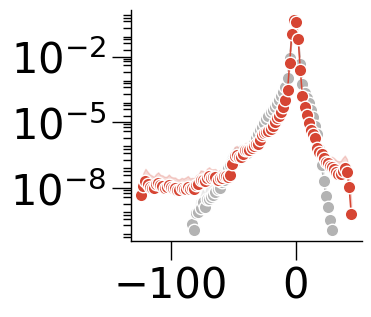

In [40]:
# plot
fig_, axis = plt.subplots(1, 1, figsize=FIG_SIZE)

# vivo
amplitude.plot_proba_dist_stats(
    axis,
    mean_vivo[mean_vivo > 0],
    ci_vivo[mean_vivo > 0],
    bins[:-1][mean_vivo > 0],
    color=(0.7, 0.7, 0.7),
    ci_color=(0.7, 0.7, 0.7),
    label="vivo",
    linestyle="-",
)

# silico
amplitude.plot_proba_dist_stats(
    axis,
    mean_sili[mean_sili > 0],
    ci_sili[mean_sili > 0],
    bins[:-1][mean_sili > 0],
    color=(0.84, 0.27, 0.2),
    ci_color=(0.84, 0.27, 0.2),
    label="silico",
    linestyle="-",
)

# legend
axis.set_yscale("log")
# axis.legend(**legend_cfg)
axis.spines[["right", "top"]].set_visible(False)
# axis.set_ylabel("Probability (ratio)")
# axis.set_xlabel("Signal-to-noise ratio (a.u)")
axis.tick_params(which="both", width=1)
axis.set_box_aspect(1)  # square axis

# show minor ticks
axis.tick_params(which="major", width=1)
# y
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
)
axis.yaxis.set_major_locator(locmaj)
axis.yaxis.set_minor_locator(locmin)
axis.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save
plt.savefig("figures/2_realism/3_snr/pdf/marques/marques_snr_all.pdf", **savefig_cfg)
plt.savefig("figures/2_realism/3_snr/svg/marques/marques_snr_all.svg", **savefig_cfg)

### Plot layer-wise

#### Layer 1

In [76]:
def plot_layer_snr(
    layer: str,
    layers_sili: list,
    layers_vivo: list,
    snr_sili: list,
    snr_vivo: list,
    n_bins: int,
):
    """plot snr distribution for specified layer

    Args:
        layer (str): _description_
        snr_sili (list): sites x timepoints
        snr_vivo (list): _description_
        n_bins (int): _description_
    """
    # 1 - get this layer
    snr_sili_layer_i = snr_sili[layers_sili == layer, :]
    snr_vivo_layer_i = snr_vivo[layers_vivo == layer, :]

    # 2 - calculate common bins (2 mins)
    snr_max_layer_i = np.max(
        [np.array(snr_vivo_layer_i).max(), np.array(snr_sili_layer_i).max()]
    )
    snr_min_layer_i = np.min(
        [np.array(snr_vivo_layer_i).min(), np.array(snr_sili_layer_i).min()]
    )
    step_layer_i = (snr_max_layer_i - snr_min_layer_i) / n_bins
    bins_layer_i = np.arange(
        snr_min_layer_i, snr_max_layer_i + step_layer_i / 2, step_layer_i
    )

    # 3 - Compute the snr pdf stats over sites (1 min)
    # vivo
    mean_vivo_layer_i, ci_vivo_layer_i = amplitude.compute_anr_proba_dist_stats(
        snr_vivo_layer_i, bins_layer_i
    )
    # silico
    (
        mean_sili_layer_i,
        ci_sili_layer_i,
    ) = amplitude.compute_anr_proba_dist_stats(snr_sili_layer_i, bins_layer_i)

    # plot
    fig_, axis = plt.subplots(1, 1, figsize=FIG_SIZE)

    # vivo
    amplitude.plot_proba_dist_stats(
        axis,
        mean_vivo_layer_i[mean_vivo_layer_i > 0],
        ci_vivo_layer_i[mean_vivo_layer_i > 0],
        bins_layer_i[:-1][mean_vivo_layer_i > 0],
        color=(0.7, 0.7, 0.7),
        ci_color=(0.7, 0.7, 0.7),
        label="vivo",
        linestyle="-",
    )

    # silico
    amplitude.plot_proba_dist_stats(
        axis,
        mean_sili_layer_i[mean_sili_layer_i > 0],
        ci_sili_layer_i[mean_sili_layer_i > 0],
        bins_layer_i[:-1][mean_sili_layer_i > 0],
        color=(0.84, 0.27, 0.2),
        ci_color=(0.84, 0.27, 0.2),
        label="silico",
        linestyle="-",
    )

    # legend
    axis.set_yscale("log")
    # axis.legend(frameon=LG_FRAMEON)
    axis.spines[["right", "top"]].set_visible(False)
    # axis.set_ylabel("Probability (ratio)")
    # axis.set_xlabel("Signal-to-noise ratio (a.u)")
    axis.tick_params(which="both", width=1)
    axis.set_box_aspect(1)  # square axis

    # show minor ticks
    axis.tick_params(which="major", width=1)
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    )
    axis.yaxis.set_major_locator(locmaj)
    axis.yaxis.set_minor_locator(locmin)
    axis.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    axis.spines[["right", "top"]].set_visible(False)
    # axis.set_xticklabels([])
    return axis

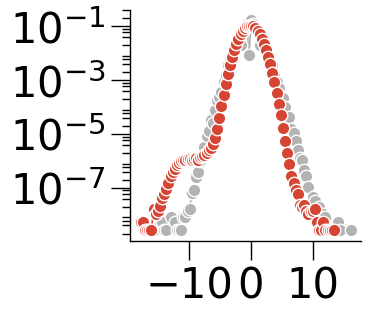

In [77]:
# layer 1
plot_layer_snr("L1", site_layers_sili, site_layers_vivo, snr_sili, snr_vivo, 100)
plt.savefig("figures/2_realism/3_snr/pdf/marques/marques_snr_layer1.pdf", **savefig_cfg)
plt.savefig("figures/2_realism/3_snr/svg/marques/marques_snr_layer1.svg", **savefig_cfg)

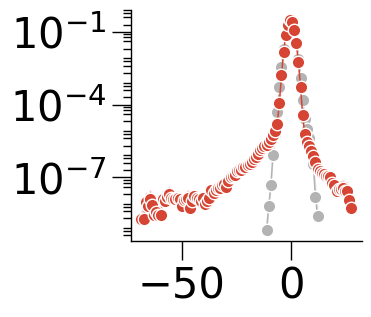

In [78]:
axis = plot_layer_snr(
    "L2_3", site_layers_sili, site_layers_vivo, snr_sili, snr_vivo, 100
)
plt.savefig(
    "figures/2_realism/3_snr/pdf/marques/marques_snr_layer2_3.pdf", **savefig_cfg
)
plt.savefig(
    "figures/2_realism/3_snr/svg/marques/marques_snr_layer2_3.svg", **savefig_cfg
)

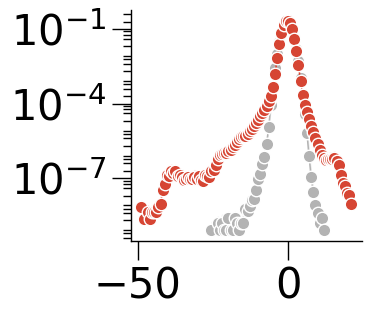

In [79]:
plot_layer_snr("L4", site_layers_sili, site_layers_vivo, snr_sili, snr_vivo, 100)
plt.savefig("figures/2_realism/3_snr/pdf/marques/marques_snr_layer4.pdf", **savefig_cfg)
plt.savefig("figures/2_realism/3_snr/svg/marques/marques_snr_layer4.svg", **savefig_cfg)

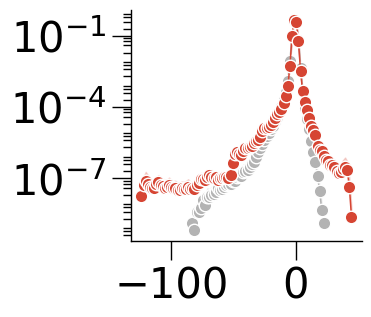

In [80]:
plot_layer_snr("L5", site_layers_sili, site_layers_vivo, snr_sili, snr_vivo, 100)
plt.savefig("figures/2_realism/3_snr/pdf/marques/marques_snr_layer5.pdf", **savefig_cfg)
plt.savefig("figures/2_realism/3_snr/svg/marques/marques_snr_layer5.svg", **savefig_cfg)

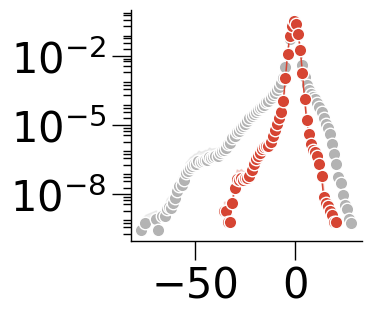

In [81]:
plot_layer_snr("L6", site_layers_sili, site_layers_vivo, snr_sili, snr_vivo, 100)
plt.savefig("figures/2_realism/3_snr/pdf/marques/marques_snr_layer6.pdf", **savefig_cfg)
plt.savefig("figures/2_realism/3_snr/svg/marques/marques_snr_layer6.svg", **savefig_cfg)

### Check rare SNRs

In [75]:
# What is the probability of observing SNRs below -100?
RARE_SNR_CUTOFF = -50

mask = snr_sili < RARE_SNR_CUTOFF
count = mask.sum()
proba = count / (snr_sili.shape[0] * snr_sili.shape[1])
print("count silico:", count)
print("proba silico:", proba)

# What is the probability of observing SNRs below -100?
mask_vivo = snr_vivo < RARE_SNR_CUTOFF
count_vivo = mask_vivo.sum()
proba_vivo = count_vivo / (snr_vivo.shape[0] * snr_vivo.shape[1])
print("count vivo:", count_vivo)
print("proba vivo:", proba_vivo)

count silico: 3889
proba silico: 8.185580386998816e-07
count vivo: 3422
proba vivo: 4.117459167244071e-07


In [ ]:
import copy

snr_sili_clean = copy.copy(snr_sili)
snr_sili_clean = copy.copy(snr_vivo)
snr_sili_clean[snr_sili_clean < -30] = np.nan

In [ ]:
# takes 3 min

N_BINS = 100

# 1 - calculate common bins (2 mins)
snr_max = np.max([np.array(snr_vivo).max(), np.array(snr_sili).max()])
snr_min = np.min([np.array(snr_vivo).min(), np.array(snr_sili).min()])
step = (snr_max - snr_min) / N_BINS
bins = np.arange(snr_min, snr_max + step / 2, step)

# 2- Compute the snr pdf stats over sites (1 min)
# vivo
mean_vivo, ci_vivo = amplitude.compute_anr_proba_dist_stats(snr_vivo, bins)
# silico
(
    mean_sili,
    ci_sili,
) = amplitude.compute_anr_proba_dist_stats(snr_sili, bins)

In [185]:
# What is the probability of observing SNRs below -25?
snr_sili_layer_i = snr_sili[layers_sili == "L1", :]
mask = snr_sili_layer_i < -10
count = mask.sum()
proba = count / (snr_sili.shape[0] * snr_sili.shape[1])
print("count:", count)
print("proba:", proba)

count: 2793
proba: 3.092449494447021e-07


In [122]:
# What is the probability of observing SNRs below -25?
snr_sili_layer_i = snr_sili[layers_sili == "L6", :]
mask = snr_sili_layer_i < -25
mask.sum() / (snr_sili_layer_i.shape[0] * snr_sili_layer_i.shape[1])

2.2008814750395682e-07

In [132]:
# What is the probability of observing SNRs below -25?
snr_vivo_layer_i = snr_vivo[layers_vivo == "L6", :]
mask = snr_vivo_layer_i < -10
mask.sum() / (snr_vivo_layer_i.shape[0] * snr_vivo_layer_i.shape[1])

0.0010503982754599059

In [189]:
# What is the maximum number of spikes that would be removed, if we dropped high SNRs (the biggest spikes) less frequent than 10-6,
# assuming each dropped sample with High SNR is a spike (in reality each spike contains many high SNR samples,
# so we get an upper bound on the number of spikes)?

prop_of_dropped_SNRs = 10e-6

# calculate upper bound on number of spike dropped
# over entire recording (across sites)
traces = PreRecording_sili.get_traces()
ntimepts = traces.shape[0]
nsites = traces.shape[1]
nsamples = int(prop_of_dropped_SNRs * ntimepts * nsites)

# calculate total period dropped
period = nsamples / SFREQ_SILICO
print("Period dropped:", period, "secs")

# calculate firing rate, if that was one unit we dropped.
duration_secs = ntimepts / SFREQ_SILICO
dropped_unit_firing_rate = nsamples / duration_secs

print("Number of samples dropped:", nsamples)
print(
    "If one sample is a spike (upper bound), all spikes would form a unit of:",
    dropped_unit_firing_rate,
    "spikes/secs",
)

Period dropped: 2.2579 secs
Number of samples dropped: 90316
If one sample is a spike (upper bound), all spikes would form a unit of: 153.5987178224751 spikes/secs


# References

(1) https://gin.g-node.org/spikeinterface/probeinterface_library/src/master/neuronexus/A1x32-Poly3-10mm-50-177/A1x32-Poly3-10mm-50-177.json

(2) Horváth et al., “Dataset of Cortical Activity Recorded with High Spatial Resolution from Anesthetized Rats.”

(3) Fiáth, R., Raducanu, B. C., Musa, S., Andrei, A., Lopez, C. M., Van Hoof, C., ... & Ulbert, I. (2018). A silicon-based neural probe with densely-packed low-impedance titanium nitride microelectrodes for ultrahigh-resolution in vivo recordings. Biosensors and Bioelectronics, 106, 86-92.  